In [147]:
import os, json

OSF_DATA = os.path.join('..', '..', 'data', 'osf_all_data.json')

osf_records = []
with open(OSF_DATA, 'r') as f:
    for line in f:
        data = json.loads(line)
        osf_records.append(data)

In [148]:
for record in osf_records:
    print(record.keys())
    break

dict_keys(['id', 'doi', 'osf_record', 'osf_authors', 'crossref_preprint', 'crossref_peerrev_publications', 'osf_peerrev_publications', 'crossref_search_results'])


In [157]:
# check consistencies between the peer-reviewed versions
# 1) from OSF: user-submitted peer-reviewed DOIs
# 2) from CrossRef: linked by CrossRef
# 3) from CrossRef search: found by searching using title and surname of first author

records_with_submitted_peerrev_dois = set()
records_with_submitted_peerrev_dois_in_crossref = set()

records_with_crossref_peerrev = set()
records_with_crossref_peerrev_in_crossref = set()
records_with_more_than_one_crossref_peerrev = 0

records_with_search_result = set()
records_with_more_than_one_search_result = 0

for record in osf_records:
    if record['osf_record']['attributes']['doi'] is not None and \
            record['osf_record']['attributes']['doi'] != \
            record['osf_record']['links']['preprint_doi'].replace('https://doi.org/', ''):
        
        records_with_submitted_peerrev_dois.add(record['id'])
        
        osf_doi = record['osf_record']['attributes']['doi']
        
        if record['osf_peerrev_publications'] is not None and 'message' in record['osf_peerrev_publications']:
            records_with_submitted_peerrev_dois_in_crossref.add(record['id'])
    else:
        osf_doi = None
        
    if len(record['crossref_peerrev_publications']) > 0 and \
        record['crossref_preprint']['message']['DOI'] != \
        record['crossref_preprint']['message']['relation']['is-preprint-of'][0]['id']:
        
        records_with_crossref_peerrev.add(record['id'])
        
        if len(record['crossref_peerrev_publications']) > 1:
            records_with_more_than_one_crossref_peerrev += 1
            
        crossref_doi = record['crossref_preprint']['message']['relation']['is-preprint-of'][0]['id']

        if 'message' in record['crossref_peerrev_publications'][0]:
            records_with_crossref_peerrev_in_crossref.add(record['id'])
    
    else:
        crossref_doi = None
            
    if len(record['crossref_search_results']) > 0:
        records_with_search_result.add(record['id'])
        
        if len(record['crossref_search_results']) > 1:
            records_with_more_than_one_search_result += 1
         
    if osf_doi is not None and crossref_doi is not None and osf_doi != crossref_doi:
        print('OSF and CrossRef DOI different{}: {} vs {}'.format(record['id'], osf_doi, crossref_doi))

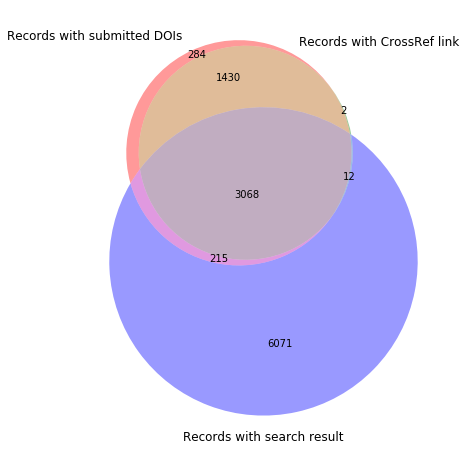

In [158]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn3

plt.figure(figsize=(8, 8))

venn3([records_with_submitted_peerrev_dois, records_with_crossref_peerrev, records_with_search_result], 
      set_labels = ('Records with submitted DOIs', 'Records with CrossRef link', 'Records with search result'))
plt.show()

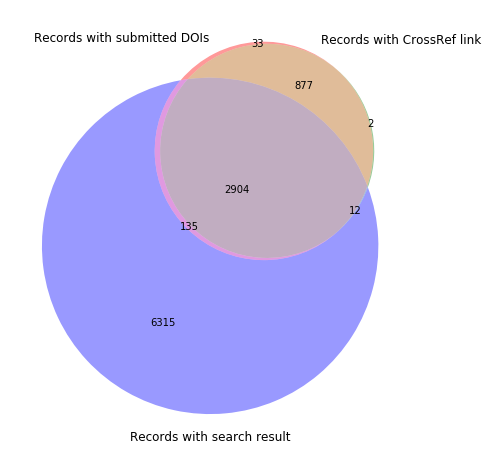

In [159]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn3

plt.figure(figsize=(8, 8))

venn3([records_with_submitted_peerrev_dois_in_crossref, records_with_crossref_peerrev_in_crossref, records_with_search_result], 
      set_labels = ('Records with submitted DOIs', 'Records with CrossRef link', 'Records with search result'))
plt.show()

In [185]:
# OSF records linked to each other by DOIs

linked_records = {}
for record in osf_records:
    provider = record['osf_record']['relationships']['provider']['links']['related']['href'].replace( \
                'https://api.osf.io/v2/providers/preprints/', '').replace('/?format=json', '')
    
    # for now, do not include inarxiv: it's just too messy
    if provider != 'inarxiv':
        linked_records[record['doi']] = { 'doi' : record['doi'], 'linked_records' : set(), 'provider' : provider }

for record in osf_records:
    record_doi = record['osf_record']['links']['preprint_doi'].replace('https://doi.org/', '')
    
    if record_doi in linked_records.keys():
        if record['osf_record']['attributes']['doi'] is not None and \
            record['osf_record']['attributes']['doi'] != record_doi and \
            record['osf_record']['attributes']['doi'] in linked_records.keys():
                linked_records[record_doi]['linked_records'].add(record['osf_record']['attributes']['doi'])

        if len(record['crossref_peerrev_publications']) > 0 and \
            record['crossref_preprint']['message']['DOI'] != \
            record['crossref_preprint']['message']['relation']['is-preprint-of'][0]['id'] and \
            record['crossref_preprint']['message']['relation']['is-preprint-of'][0]['id'] in linked_records.keys():

            linked_records[record_doi]['linked_records'].add(\
                record['crossref_preprint']['message']['relation']['is-preprint-of'][0]['id'])

        if len(record['crossref_search_results']) > 0:
            for result in record['crossref_search_results']:
                if result['DOI'] in linked_records.keys():
                    linked_records[record_doi]['linked_records'].add(result['DOI'])

In [186]:
for doi, data in linked_records.items():
    if len(data['linked_records']) > 0:
        print(data)

{'doi': '10.31219/osf.io/s24hr', 'linked_records': {'10.31219/osf.io/xg4w3'}, 'provider': 'osf'}
{'doi': '10.31219/osf.io/xg4w3', 'linked_records': {'10.31219/osf.io/s24hr'}, 'provider': 'osf'}
{'doi': '10.31228/osf.io/avxf5', 'linked_records': {'10.31228/osf.io/ftqyw'}, 'provider': 'lawarxiv'}
{'doi': '10.31229/osf.io/6cf8j', 'linked_records': {'10.31229/osf.io/qxy3d'}, 'provider': 'lissa'}
{'doi': '10.31219/osf.io/8v5cd', 'linked_records': {'10.31219/osf.io/e2wu9'}, 'provider': 'osf'}
{'doi': '10.31219/osf.io/j3dxw', 'linked_records': {'10.31219/osf.io/s25e9'}, 'provider': 'osf'}
{'doi': '10.31219/osf.io/z68xc', 'linked_records': {'10.31219/osf.io/6y5aw'}, 'provider': 'osf'}
{'doi': '10.31219/osf.io/6y5aw', 'linked_records': {'10.31219/osf.io/z68xc'}, 'provider': 'osf'}
{'doi': '10.31219/osf.io/mp72e', 'linked_records': {'10.31219/osf.io/vfx8b'}, 'provider': 'osf'}
{'doi': '10.31219/osf.io/sn4d6', 'linked_records': {'10.31219/osf.io/rvhc9'}, 'provider': 'osf'}
{'doi': '10.31219/osf.i

In [ ]:
# how many inarxiv records are similar??

In [160]:
len(records_with_submitted_peerrev_dois)

4997

In [171]:
a

35

In [172]:
b

35

In [145]:
# check consistencies between the peer-reviewed versions
# 1) from OSF: user-submitted peer-reviewed DOIs
# 2) from CrossRef: linked by CrossRef
# 3) from CrossRef search: found by searching using title and surname of first author

records_with_submitted_peerrev_dois = set()
records_with_submitted_peerrev_dois_in_crossref = set()

records_with_crossref_peerrev = set()
records_with_crossref_peerrev_in_crossref = set()
records_with_more_than_one_crossref_peerrev = 0

records_with_search_result = set()
records_with_more_than_one_search_result = 0

ia = 0
nia = 0
groups = set()

for record in osf_records:
    if record['osf_record']['attributes']['doi'] is not None:
        records_with_submitted_peerrev_dois.add(record['id'])
        
        osf_doi = record['osf_record']['attributes']['doi']
        
        if record['osf_peerrev_publications'] is not None and 'message' in record['osf_peerrev_publications']:
            records_with_submitted_peerrev_dois_in_crossref.add(record['id'])
    else:
        osf_doi = None
        
    if len(record['crossref_peerrev_publications']) > 0:
        records_with_crossref_peerrev.add(record['id'])
        
        if len(record['crossref_peerrev_publications']) > 1:
            records_with_more_than_one_crossref_peerrev += 1
            
        crossref_doi = record['crossref_preprint']['message']['relation']['is-preprint-of'][0]['id']

        if 'message' in record['crossref_peerrev_publications'][0]:
            records_with_crossref_peerrev_in_crossref.add(record['id'])
    
    else:
        crossref_doi = None
            
    if len(record['crossref_search_results']) > 0:
        records_with_search_result.add(record['id'])
        
        if len(record['crossref_search_results']) > 1:
            records_with_more_than_one_search_result += 1
        
#             a = False
#             crossref_search_dois = set()
#             for result in record['crossref_search_results']:
#                 crossref_search_dois.add(result['DOI'])
                
#                 if 'group-title' in result:
#                     groups.add(result['group-title'])
# #                 if 'group-title' in result and result['group-title'] == 'INA-Rxiv':
# #                     a = True
# #                 elif  'group-title' in result:
# #                     print(result['group-title'])
# # #             print(crossref_search_dois)
# #             if a:
# #                 ia += 1
# #             else:
# #                 nia += 1
#         else:
#             if 'group-title' in record['crossref_search_results'][0]:
#                 groups.add(record['crossref_search_results'][0]['group-title'])
    if osf_doi is not None and crossref_doi is not None and osf_doi != crossref_doi:
        print('OSF and CrossRef DOI different{}: {} vs {}'.format(record['id'], osf_doi, crossref_doi))

In [141]:
ia

511

In [142]:
nia

1076

In [146]:
groups

{'ARTS & HUMANITIES',
 'AfricArXiv',
 'AgriXiv',
 'Animal Behavior and Cognition',
 'Arabixiv',
 'BEHAVIORAL SCIENCES',
 'BIOLOGY',
 'BITSS',
 'Bioinformatics',
 'BodoArXiv',
 'CHEMISTRY',
 'ECSarXiv',
 'ENGINEERING',
 'EarthArXiv',
 'EcoEvoRxiv',
 'Ecology',
 'Evolutionary Biology',
 'FocUS Archive',
 'Frenxiv',
 'Genetics',
 'Genomics',
 'INA-Rxiv',
 'JMIR Aging',
 'JMIR Mental Health',
 'JMIR mHealth and uHealth',
 'LIFE SCIENCES',
 'LIS Scholarship Archive',
 'LawArXiv',
 'MATERIALS SCIENCE',
 'MATHEMATICS & COMPUTER SCIENCE',
 'MEDICINE & PHARMACOLOGY',
 'MarXiv',
 'MediArXiv',
 'MetaArXiv',
 'Microbiology',
 'MindRxiv',
 'Neuroscience',
 'NutriXiv',
 'Open Science Framework',
 'PHYSICAL SCIENCES',
 'PaleorXiv',
 'PeerJ PrePrints',
 'PeerJ Preprints',
 'PsyArXiv',
 'SOCIAL SCIENCES',
 'Scientific Communication and Education',
 'SocArXiv',
 'Systems Biology',
 'Thesis Commons',
 'engrXiv',
 'other'}

In [ ]:
# non-English documents???

In [189]:
from langdetect import detect

lang = detect("Global Value Chain memandang ekonomi global sebagai jaringan kompleks yang menghubungkan para pemasok dan pembeli yang terintegrasi dan digerakkan oleh perusahaan multinasional sebagai perusahaan utama. Selain itu ada pula International Strategic Alliance, yang akan sukses jika dibangun dari waktu ke waktu. Selain itu, berbagai macam usaha dapat dilakukan sejak adanya globalisasi. Hal tersebut memunculkan adanya model bisnis baru yakni perusahaan sosial.")

print(lang)

id


In [190]:
from textblob import TextBlob
b = TextBlob("bonjour")
b.detect_language()

'fr'

In [196]:
from polyglot.detect import Detector

mixed_text = u"""
China (simplified Chinese: 中国; traditional Chinese: 中國),
officially the People's Republic of China (PRC), is a sovereign state
located in East Asia.
"""
for language in Detector(mixed_text).languages:
    print(language)

ModuleNotFoundError: No module named 'icu'

In [139]:
result

{'indexed': {'date-parts': [[2019, 6, 27]],
  'date-time': '2019-06-27T01:12:18Z',
  'timestamp': 1561597938461},
 'publisher-location': 'Abingdon, Oxon ; New York, NY : Routledge, 2019.',
 'edition-number': '1',
 'reference-count': 1,
 'publisher': 'Routledge',
 'isbn-type': [{'value': '9781315162782', 'type': 'electronic'}],
 'content-domain': {'domain': [], 'crossmark-restriction': False},
 'published-print': {'date-parts': [[2019, 1, 4]]},
 'DOI': '10.4324/9781315162782-7',
 'type': 'book-chapter',
 'created': {'date-parts': [[2019, 1, 10]],
  'date-time': '2019-01-10T02:37:49Z',
  'timestamp': 1547087869000},
 'page': '76-90',
 'source': 'Crossref',
 'is-referenced-by-count': 0,
 'title': ['Knowledge commons'],
 'prefix': '10.4324',
 'author': [{'given': 'Michael J.',
   'family': 'Madison',
   'sequence': 'first',
   'affiliation': []},
  {'given': 'Brett M.',
   'family': 'Frischmann',
   'sequence': 'additional',
   'affiliation': []},
  {'given': 'Katherine J.',
   'family': '

In [ ]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn3

plt.figure(figsize=(8, 8))

venn3([records_with_submitted_peerrev_dois, records_with_crossref_peerrev, records_with_search_result], 
      set_labels = ('Records with submitted DOIs', 'Records with CrossRef link', 'Records with search result'))
plt.show()

In [ ]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn3

plt.figure(figsize=(8, 8))

venn3([records_with_submitted_peerrev_dois_in_crossref, records_with_crossref_peerrev_in_crossref, records_with_search_result], 
      set_labels = ('Records with submitted DOIs', 'Records with CrossRef link', 'Records with search result'))
plt.show()

In [ ]:
print('RECORDS WITH USER-SUBMITTED DOIs: {}'.format(len(records_with_submitted_peerrev_dois)))
print('USER-SUBMITTED DOIs WITH CROSSREF RECORDS: {}'.format(len(records_with_submitted_peerrev_dois_in_crossref)))
print()

print('RECORDS WITH LINKED CROSSREF "PEER-REVIEWED" DOIs: {}'.format(len(records_with_crossref_peerrev)))
print('LINKED CROSSREF "PEER-REVIEWED" DOIs ACTUALLY IN CROSSREF: {}'.format(len(records_with_crossref_peerrev_in_crossref)))
print('RECORDS WITH MORE THAN ONE LINKED CROSSREF "PEER-REVIEWED" RECORDS: {}'.format(records_with_more_than_one_crossref_peerrev))
print()

print('RECORDS WITH CROSSREF SEARCH RESULTS: {}'.format(len(records_with_search_result)))
print('RECORDS WITH MORE THAN ONE CROSSREF SEARCH RESULT: {}'.format(records_with_more_than_one_search_result))

In [ ]:
with open('')

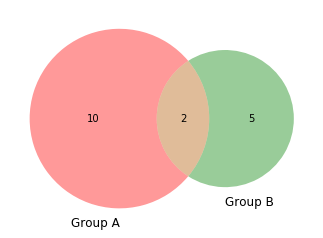

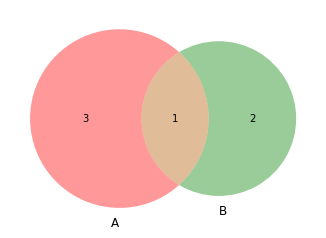

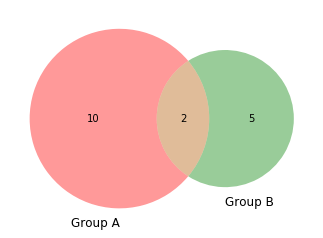

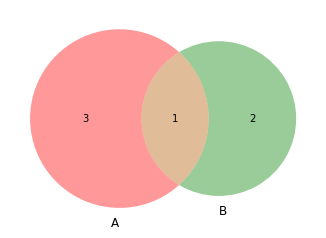

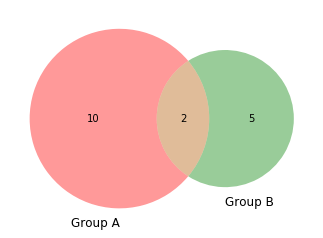

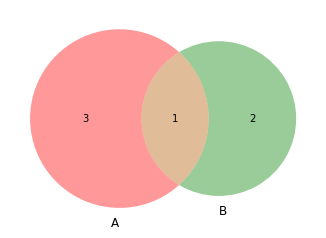

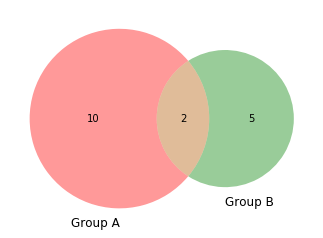

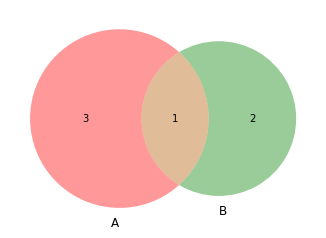

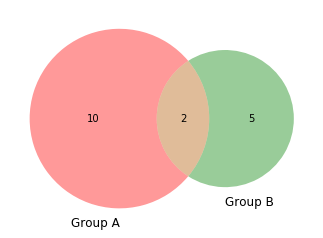

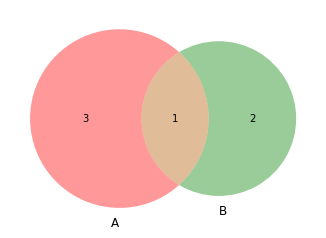

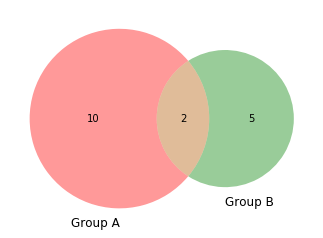

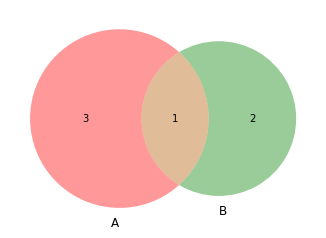

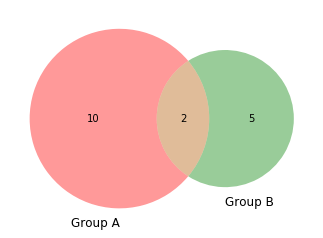

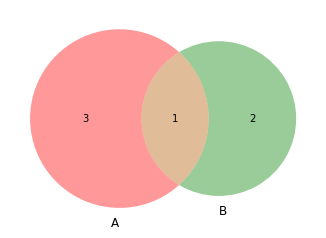

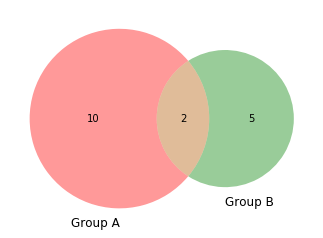

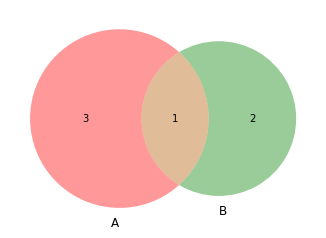

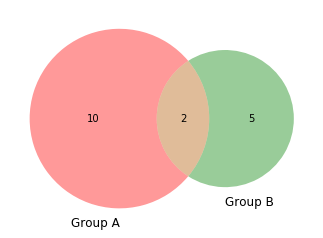

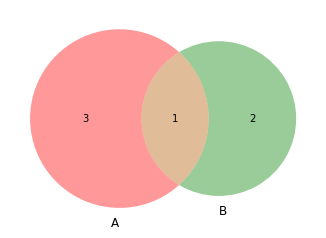

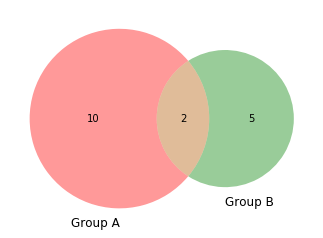

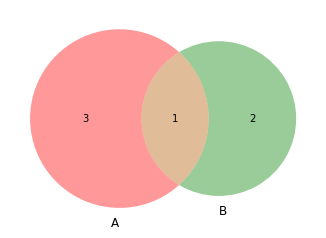

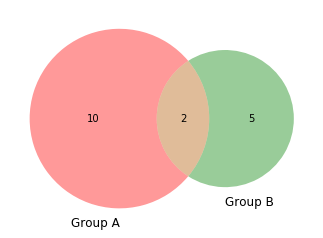

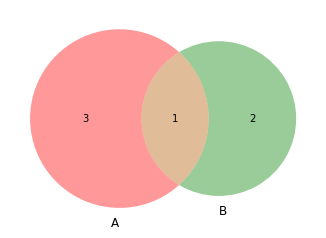

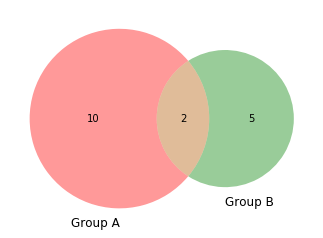

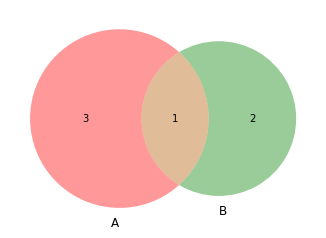

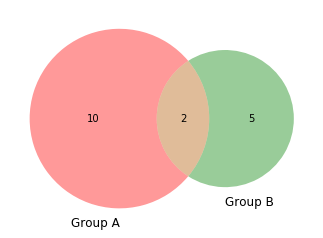

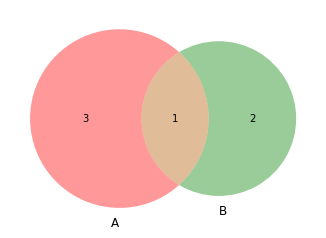

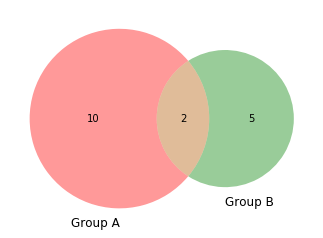

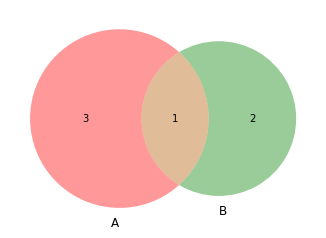

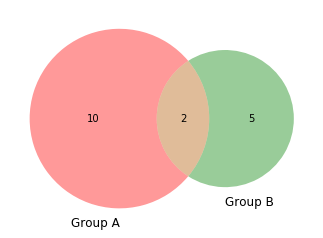

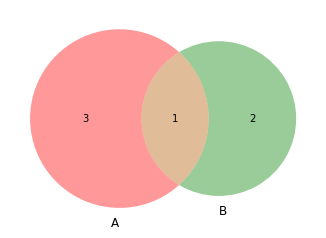

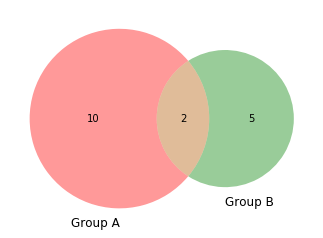

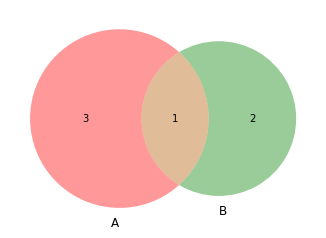

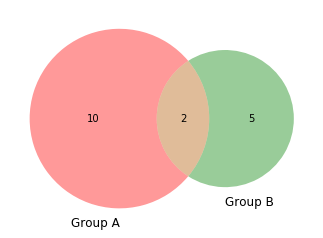

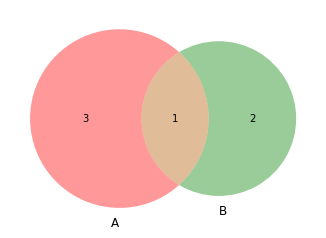

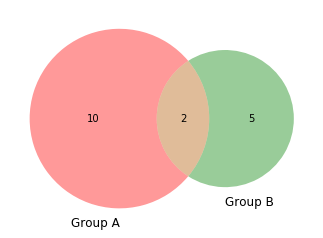

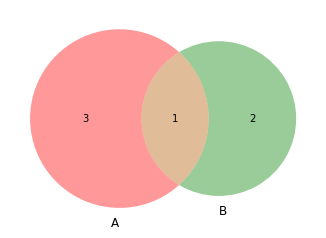

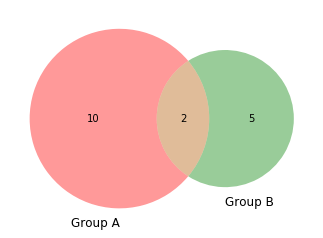

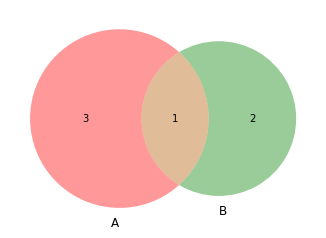

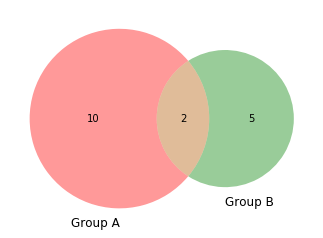

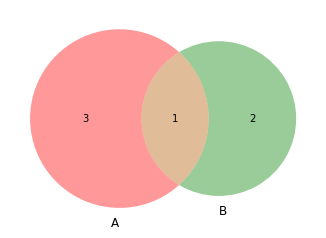

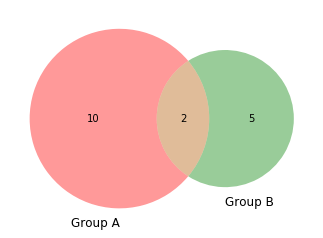

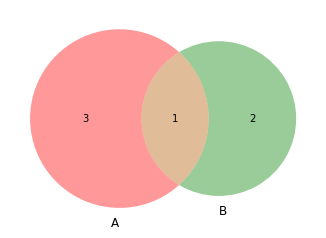

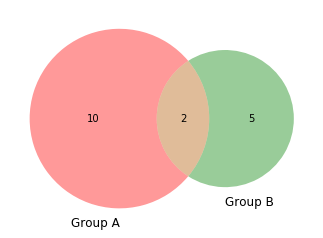

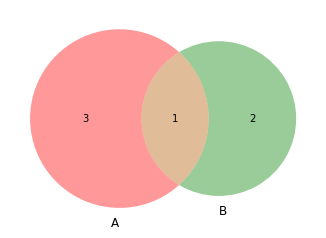

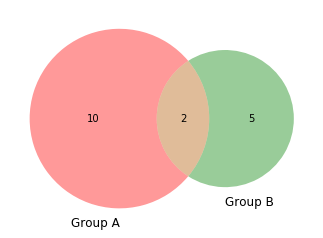

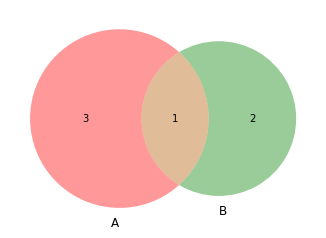

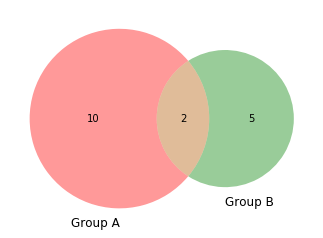

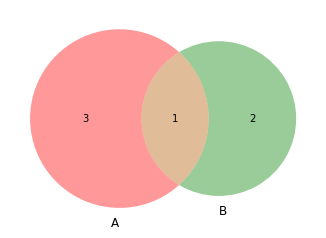

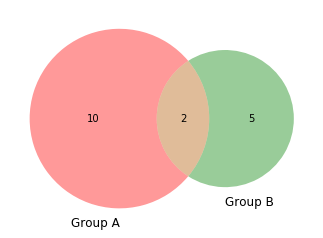

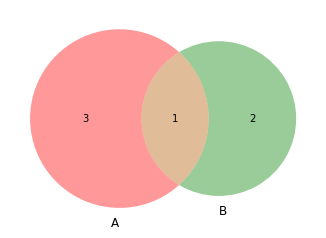

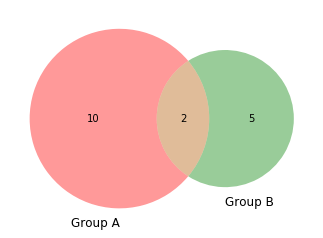

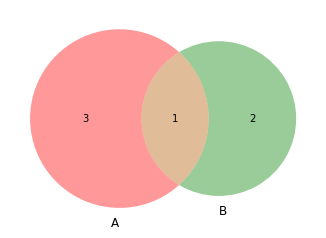

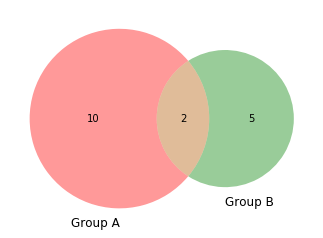

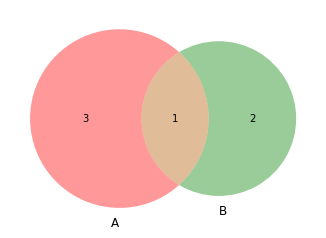

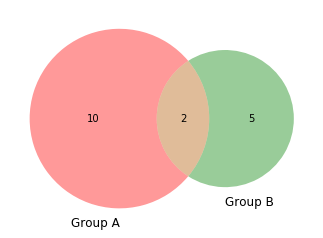

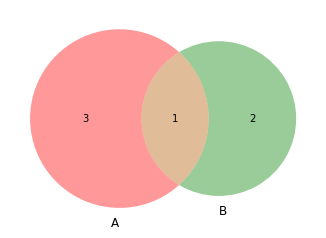

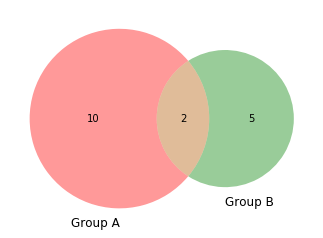

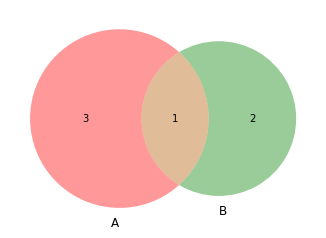

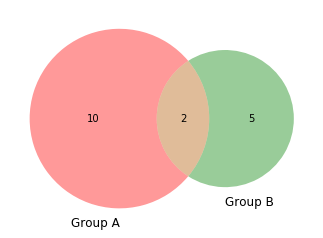

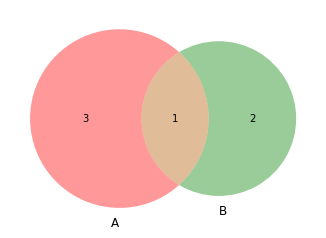

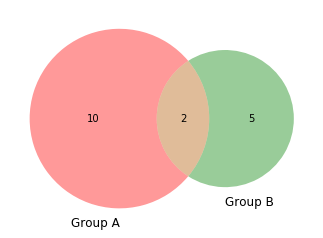

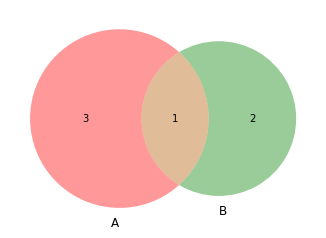

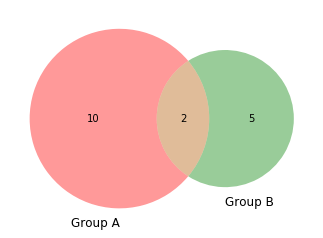

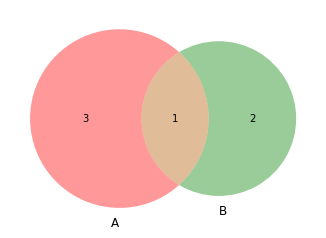

KeyboardInterrupt: 

In [96]:
# check consistencies between the peer-reviewed versions
# 1) from OSF: user-submitted peer-reviewed DOIs
# 2) from CrossRef: linked by CrossRef
# 3) from CrossRef search: found by searching using title and surname of first author

records_with_submitted_peerrev_dois = 0
records_with_submitted_peerrev_dois_in_crossref = 0

records_with_crossref_peerrev = 0
records_with_more_than_one_crossref_peerrev = 0

records_with_search_result = 0
records_with_more_than_one_search_result = 0

for record in osf_records:
    if record['osf_record']['attributes']['doi'] is not None:
        records_with_submitted_peerrev_dois += 1
    if record['osf_peerrev_publications'] is not None and 'message' in record['osf_peerrev_publications']:
        records_with_submitted_peerrev_dois_in_crossref += 1
        
    if len(record['crossref_peerrev_publications']) > 0:
        records_with_crossref_peerrev += 1
        
        if len(record['crossref_peerrev_publications']) > 1:
            records_with_more_than_one_crossref_peerrev += 1
            
    if len(record['crossref_search_results']) > 0:
        records_with_search_result += 1
        
        if len(record['crossref_search_results']) > 1:
            records_with_more_than_one_search_result += 1
        
        import matplotlib.pyplot as plt
        from matplotlib_venn import venn2

        # First way to call the 2 group Venn diagram:
        venn2(subsets = (10, 5, 2), set_labels = ('Group A', 'Group B'))
        plt.show()

        # Second way
        venn2([set(['A', 'B', 'C', 'D']), set(['D', 'E', 'F'])])
        plt.show()


In [81]:
print('RECORDS WITH USER-SUBMITTED DOIs: {}'.format(records_with_submitted_peerrev_dois))
print('USER-SUBMITTED DOIs WITH CROSSREF RECORDS: {}'.format(records_with_submitted_peerrev_dois_in_crossref))
print()

print('RECORDS WITH LINKED CROSSREF "PEER-REVIEWED" RECORDS: {}'.format(records_with_crossref_peerrev))
print('RECORDS WITH MORE THAN ONE LINKED CROSSREF "PEER-REVIEWED" RECORDS: {}'.format(records_with_more_than_one_crossref_peerrev))
print()

print('RECORDS WITH CROSSREF SEARCH RESULTS: {}'.format(records_with_search_result))
print('RECORDS WITH MORE THAN ONE CROSSREF SEARCH RESULT: {}'.format(records_with_more_than_one_search_result))

RECORDS WITH USER-SUBMITTED DOIs: 5034
USER-SUBMITTED DOIs WITH CROSSREF RECORDS: 3986

RECORDS WITH LINKED CROSSREF "PEER-REVIEWED" RECORDS: 4550
RECORDS WITH MORE THAN ONE LINKED CROSSREF "PEER-REVIEWED" RECORDS: 0

RECORDS WITH CROSSREF SEARCH RESULTS: 9854
RECORDS WITH MORE THAN ONE CROSSREF SEARCH RESULT: 1707


In [39]:
records_with_submitted_peerrev_dois_in_crossref

3986

In [20]:
for record in osf_records:
    osf_dp = parse_date(record['osf_record']['attributes']['date_published'][:10])
    
    if 'message' in record['crossref_preprint']:
        crossref_dp = '-'.join([str(dt) for dt in record['crossref_preprint']['message']['issued']['date-parts'][0]])
        
        
        parse_date(
        if parse_date(osf_dp[:10]) != parse_date(crossref_dp):
            input('a')

In [17]:
# parse date string and ignore the microseconds

from datetime import datetime

def parse_date(datestr):
    try:
        dt = datetime.strptime(datestr, '%Y-%m-%d')
        dt_format = 'ymd'
    except:
        try:
            dt = datetime.strptime(datestr, '%Y-%m')
            dt_format = 'ym'
        except:
            dt = datetime.strptime(datestr, '%Y')
            dt_format = 'y'
    return dt, dt_format

In [38]:
def get_earliest_specific_date(record):
    try:
        published_online_date, published_online_format = \
            parse_date('-'.join([str(dt) for dt in record['published-online']['date-parts'][0]]))
    except:
        published_online_date = None
        
    try:
        published_print_date, published_print_format = \
            parse_date('-'.join([str(dt) for dt in record['published-print']['date-parts'][0]]))
    except:
        published_print_date = None
    
    try:
        issued_date, issued_format = \
            parse_date('-'.join([str(dt) for dt in record['issued']['date-parts'][0]]))
    except:
        issued_date = None
        
    try:
        created_date, created_format = \
            parse_date('-'.join([str(dt) for dt in record['created']['date-parts'][0]]))
    except:
        created_date = None
    
    # both published online and published print dates are not provided
    if published_online_date is None and published_print_date is None:
        if issued_date is not None:
            return issued_date, issued_format
        else:
            return created_date, created_format
    else:
        # so far, issued is always equal to either published_online or published_print (except for 1 case)
        # still, check if this is not the case!
        if published_online_date != issued_date and published_print_date != issued_date:
            print('--ISSUED DATE INCONSISTENCY--')
            print(published_online_date)
            print(published_print_date)
            print(issued_date)
        
        # both published online and published print dates are available
        if published_online_date is not None and published_print_date is not None:
            # if both dates have the same specificity, return the earlier date
            if len(published_online_format) == len(published_print_format):
                if published_online_date < published_print_date:
                    return published_online_date, published_online_format
                else:
                    return published_print_date, published_print_format
            else:
                # if they have the same year, compare the months or return more specific date
                if published_online_date.year == published_print_date.year:
                    
                    # if one of the dates contains only the year, return the more specific date
                    if published_online_format == 'y':
                        return published_print_date, published_print_format
                    elif published_print_format == 'y':
                        return published_online_date, published_online_format
                    else:
                        # if one of the dates contains only the year and month, return the more specific date
                        if published_online_date.month == published_print_date.month:
                            if published_online_format == 'ym':
                                return published_print_date, published_print_format
                            elif published_print_format == 'ym':
                                return published_online_date, published_online_format
                            
                        # if different months, return the earlier date regardless of specificity
                        elif published_online_date.month < published_print_date.month:
                            return published_online_date, published_online_format
                        else:
                            return published_print_date, published_print_format
                        
                # if different years, return the earlier date regardless of specificity
                elif published_online_date.year < published_print_date.year:
                    return published_online_date, published_online_format
                else:
                    return published_print_date, published_print_format
                    
#                 this block of code returns the more specific date (regardless if the other date is earlier)
#                 if len(published_online_format) > len(published_print_format):
#                     return published_online_date, published_online_format
#                 else:
#                     return published_print_date, published_print_format
        else:
            # only one of published_online or published_print is available  
            return issued_date, issued_format

In [79]:
import os, json

CROSSREF_OSF = os.path.join('..', '..', 'data', 'crossref_results_from_osf_data.json')

preprints = 0
postprints = 0
unsure = 0

peerrev_pub_is_preprint = 0

records_with_user_peerrev_doi = 0

user_crossref_peerrev_same = 0

cr_pubs = 0
with open(CROSSREF_OSF, 'r') as f:
    for line in f:
        data = json.loads(line)
        if 'message' in data['preprint']:
            # note that preprint_date_format is assumed to be ymd (this is the case in the current dataset)
            preprint_date, preprint_date_format = parse_date('-'.join(
                [str(dt) for dt in data['preprint']['message']['posted']['date-parts'][0]]))
            
        if data['osf_publication'] is not None and 'message' in data['osf_publication']:
            if data['osf_publication']['message']['type'] == 'posted-content':
                peerrev_pub_is_preprint += 1
            
            osf_pub_date, osf_pub_date_format = get_earliest_specific_date(data['osf_publication']['message'])
            
            if (osf_pub_date.year == preprint_date.year and osf_pub_date_format == 'y') or \
                (osf_pub_date.year == preprint_date.year and \
                osf_pub_date.month == preprint_date.month and \
                osf_pub_date_format == 'ym'):
                
                # if we only have year data or if the osf_pub and preprint_date are in the same month
                unsure += 1
            else:
                if preprint_date < osf_pub_date:
                    preprints += 1
                else:
                    postprints += 1
                    
            records_with_user_peerrev_doi += 1
        
        if len(data['crossref_publications']) > 0:
            cr_pubs += 1
            
#             osf_crossref_same_doi = False
            for pub in data['crossref_publications']:
                if 'message' in pub and \
                    data['osf_publication'] is not None and \
                    data['osf_publication']['message']['DOI'] == pub['message']['DOI']:
                    
                    user_crossref_peerrev_same += 1
                    break

--ISSUED DATE INCONSISTENCY--
None
2019-01-04 00:00:00
2019-01-01 00:00:00
--ISSUED DATE INCONSISTENCY--
None
2018-01-12 00:00:00
2018-01-01 00:00:00
--ISSUED DATE INCONSISTENCY--
None
2018-03-26 00:00:00
2018-01-01 00:00:00
--ISSUED DATE INCONSISTENCY--
None
2017-12-01 00:00:00
2017-01-01 00:00:00
--ISSUED DATE INCONSISTENCY--
None
2018-07-24 00:00:00
2018-01-01 00:00:00
--ISSUED DATE INCONSISTENCY--
2018-01-02 00:00:00
2018-09-01 00:00:00
2018-01-01 00:00:00


In [60]:
unsure

168

In [61]:
preprints

1186

In [62]:
postprints

2632

In [81]:
cr_pubs

4549

In [66]:
peerrev_pub_is_preprint

79

In [78]:
user_crossref_peerrev_same

3817

In [80]:
records_with_user_peerrev_doi

3986